In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.externals import joblib
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import os
#os.chdir(r'C:\Users\DELL\Desktop\EDUCATE\DATA CSV\PRSA_Data_20130301-20170228')
from IPython.display import display

In [203]:
# get the name of the csv file 
file = 'PRSA_Data_Aotizhongxin_20130301-20170228.csv' 

# read the csv file into a pandas DataFrame using the pd.read_csv()
data = pd.read_csv(file)
data.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


In [204]:
# print out the info of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 18 columns):
No         35064 non-null int64
year       35064 non-null int64
month      35064 non-null int64
day        35064 non-null int64
hour       35064 non-null int64
PM2.5      34139 non-null float64
PM10       34346 non-null float64
SO2        34129 non-null float64
NO2        34041 non-null float64
CO         33288 non-null float64
O3         33345 non-null float64
TEMP       35044 non-null float64
PRES       35044 non-null float64
DEWP       35044 non-null float64
RAIN       35044 non-null float64
wd         34983 non-null object
WSPM       35050 non-null float64
station    35064 non-null object
dtypes: float64(11), int64(5), object(2)
memory usage: 4.8+ MB


In [205]:
# check for duplicated values and null values
print('Are there any duplicated values in our data ? : {}\n'.format(data.duplicated().any()))
print('The total number of null values in each colum:')
display(data.isnull().sum())

Are there any duplicated values in our data ? : False

The total number of null values in each colum:


No            0
year          0
month         0
day           0
hour          0
PM2.5       925
PM10        718
SO2         935
NO2        1023
CO         1776
O3         1719
TEMP         20
PRES         20
DEWP         20
RAIN         20
wd           81
WSPM         14
station       0
dtype: int64

In [206]:
# fill in the missing values with the mean of the particular column
data.fillna(value=data.mean(),inplace=True)

# let's check the data again if there are any missing values
data.isnull().any()

No         False
year       False
month      False
day        False
hour       False
PM2.5      False
PM10       False
SO2        False
NO2        False
CO         False
O3         False
TEMP       False
PRES       False
DEWP       False
RAIN       False
wd          True
WSPM       False
station    False
dtype: bool

In [207]:
# create a datetime column using the year,month,day and hour columns.
years = data['year'].values
months = data['month'].values
days = data['day'].values
hours = data['hour'].values
full_date = []

for i in range(data.shape[0]):
    date_time = str(years[i])+'-'+str(months[i])+'-'+str(days[i])+' '+str(hours[i])+':'+str(0)
    full_date.append(date_time)

dates = pd.to_datetime(full_date)
dates = pd.DataFrame(dates,columns=['date'])
data = pd.concat([dates,data],axis=1)

data.head()

,date,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,2013-03-01 00:00:00,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2013-03-01 01:00:00,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,2013-03-01 02:00:00,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,2013-03-01 03:00:00,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,2013-03-01 04:00:00,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


### Training the LinearRegression model

In [208]:
# now we drop the unwanted columns or features from our data
unwanted_cols = ['date','No','year','month','day','hour','wd','station']
newdata = data.drop(unwanted_cols,axis=1)
newdata.head()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,4.4
1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,4.7
2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,5.6
3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,3.1
4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,2.0


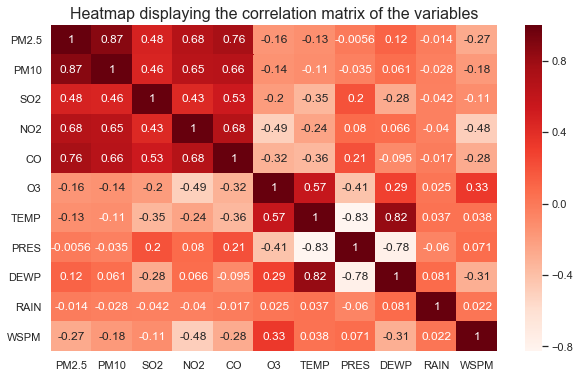

In [209]:
# let's try and visualize the relationships between the remaining features of the data
plt.figure(figsize=(10,6))
sns.heatmap(newdata.corr(),cmap=plt.cm.Reds,annot=True)
plt.title('Heatmap displaying the correlation matrix of the variables',fontsize=16)
plt.show()

In [172]:
# we also drop the PRESSURE,DEWPOINT, and RAIN as there isn't any linear relationship between them
# and the outcome variable.
newdata = newdata.drop(['PRES','RAIN','DEWP'],axis=1)
newdata.head()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,WSPM
0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,4.4
1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,4.7
2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,5.6
3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,3.1
4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,2.0


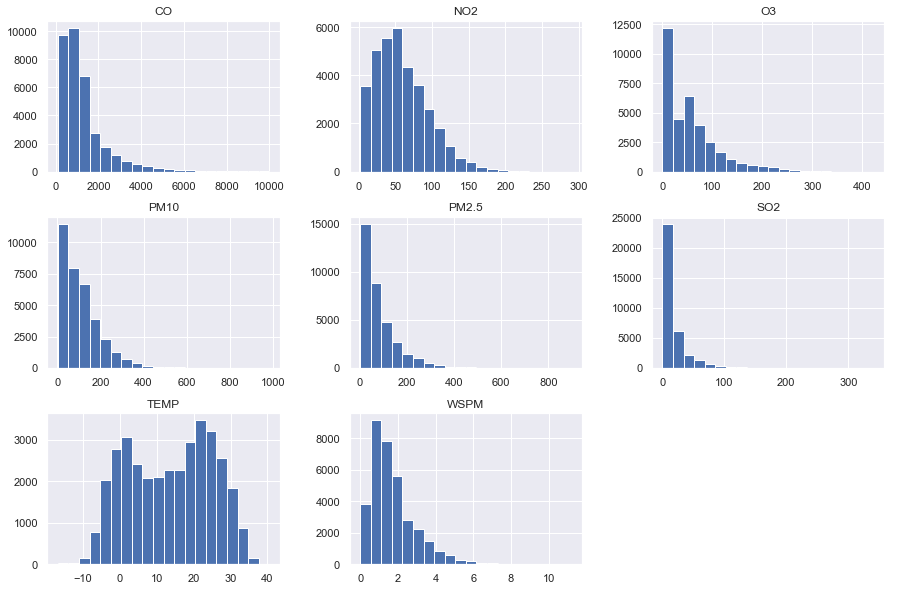

In [173]:
# now we visulaize the distributions of the features
newdata.hist(figsize=(15,10),bins=20)
plt.title('Distribution of the features',fontsize=16)
plt.show()

In [174]:
# PM10 is skewed to the right so we log transform the values to normalize the distribution
newdata['PM10'] = np.log(newdata['PM10'])

# we split the data into predictor variables and Outcome variable
X = newdata.drop('PM10',axis=1)
y = newdata['PM10']

# we need to scale or normalize the predictor variables since they are not on the same
# scale and some of their distributions are skewed.
X_scaled =  preprocessing.scale(X)
X_scaled = pd.DataFrame(X_scaled,columns=X.columns)

# print the scaled predictor variables.
X_scaled.head()

,PM2.5,SO2,NO2,CO,O3,TEMP,WSPM
0,-0.971987,-0.594053,-1.430285,-0.809141,0.365570,-1.253510,2.235814
1,-0.922631,-0.594053,-1.430285,-0.809141,0.365570,-1.288611,2.485022
2,-0.934970,-0.549641,-1.348251,-0.809141,0.294746,-1.288611,3.232647
3,-0.947309,-0.283168,-1.320906,-0.809141,0.277040,-1.314937,1.155913
4,-0.984326,-0.238756,-1.293562,-0.809141,0.277040,-1.367589,0.242150


In [175]:
# we now split out data into train and test data
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=.2,random_state=0)

# instantiate the linear regression model
lin_model = LinearRegression()
lin_model.fit(X_train,y_train)   # fit the model

# we now score the model
print('Score on train data: {}\n'.format(lin_model.score(X_train,y_train)))
print('Score on test data: {}'.format(lin_model.score(X_test,y_test)))

Score on train data: 0.6204329590027412

Score on test data: 0.6166580098773039


In [176]:
prediction = lin_model.predict(X_test)
mse = mean_squared_error(y_test,prediction)
accuracy = r2_score(y_test,prediction)

print('Mean Squared Error: {}\n'.format(mse))
print('Overall model accuracy: {}'.format(accuracy))

Mean Squared Error: 0.3706596061674226

Overall model accuracy: 0.616658009877304


# Ensemble methods

For ensemble methods (DecisionTreeRegressor,RandomForestRegressor,and GradientBoostingRegressor),we include the pressure and rain features and we won't scale the predictor variables,neither would we log transform the outcome variable.

In [177]:
ensemble_data = data.drop(unwanted_cols,axis=1)

# we split the data into predictor variables and Outcome variable
X = ensemble_data.drop('PM10',axis=1)
y = ensemble_data['PM10']

# split the data into train and test data
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=.2)

### DecisionTreeRegressor

we will now fit a decision tree regression model on the data and tune some of its parameters to increase the accuracy.

In [178]:
# we go ahead to use the ensemble methods as the LinearRegression model has a low accuracy
# on both the test and train data.
decision_tree = DecisionTreeRegressor(max_depth=5,
                                     max_features='auto',
                                     min_samples_split=3,
                                     min_samples_leaf=2) 

decision_tree.fit(xtrain,ytrain)    # fit the model

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features='auto',
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=3, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [179]:
# we now score the model
print('Score on train data: {}\n'.format(decision_tree.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(decision_tree.score(xtest,ytest)))

tree_pred = decision_tree.predict(xtest)
tree_mse = mean_squared_error(ytest,tree_pred)
tree_accuracy = r2_score(ytest,tree_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(tree_mse)))
print('Overall model accuracy: {}'.format(tree_accuracy))

Score on train data: 0.7922638928092476

Score on test data: 0.7926867613943487

Root Mean Squared Error: 42.6569657176239

Overall model accuracy: 0.7926867613943487


In [180]:
# We now tune the parameters of the model to see if we can increase the accuracy
params = {'max_depth':[3,4,5,6,7],
         'max_features':['auto','sqrt','log2'],
         'min_samples_split':[2,3,4,5,6,7,8,9,10],
         'min_samples_leaf':[2,3,4,5,6,7,8,9,10]}

tree = DecisionTreeRegressor()

# initialize the grid search for the best parameters
tree_search = GridSearchCV(tree,param_grid=params,
                          n_jobs=-1,cv=5)

tree_search.fit(xtrain,ytrain)   # fit the model

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=None,
                                             splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                 

In [181]:
# we now score the model
print('Score on train data: {}\n'.format(tree_search.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(tree_search.score(xtest,ytest)))
print('Best parameters found:')
display(tree_search.best_params_)

tree_search_pred = tree_search.predict(xtest)
tree_search_mse = mean_squared_error(ytest,tree_search_pred)
tree_search_accuracy = r2_score(ytest,tree_search_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(tree_search_mse)))
print('Overall model accuracy: {}'.format(tree_search_accuracy))

Score on train data: 0.8256408673954182

Score on test data: 0.8132074567118636

Best parameters found:


{'max_depth': 7,
 'max_features': 'auto',
 'min_samples_leaf': 8,
 'min_samples_split': 2}

Root Mean Squared Error: 40.49078620398795

Overall model accuracy: 0.8132074567118636


### RandomForestRegressor

we now fit a random forest regression model on the data to see if we would get a better accuracy results than that of the decision tree regression model.

In [182]:
# instantiate the RandomForestRegressor model and fit the model on the training data
forest = RandomForestRegressor(n_estimators=100,
                              max_depth=7,
                              max_features='auto',
                              min_samples_split=7,
                              min_samples_leaf=3)

forest.fit(xtrain,ytrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=7,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [183]:
# we now score the model
print('Score on train data: {}\n'.format(forest.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(forest.score(xtest,ytest)))

forest_pred = forest.predict(xtest)
forest_mse = mean_squared_error(ytest,forest_pred)
forest_accuracy = r2_score(ytest,forest_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(forest_mse)))
print('Overall model accuracy: {}'.format(forest_accuracy))

Score on train data: 0.848376143071962

Score on test data: 0.8390040203364059

Root Mean Squared Error: 37.59100678334799

Overall model accuracy: 0.839004020336406


In [184]:
# we now tune the parameters of the RandomForestRegressor model using RandomizedSearchCV to 
# find the best parameters and increase the accuracy of the model

params['n_estimators'] = [100,200,300,400,500]

# instantiate the model
random_forest = RandomForestRegressor()

# perform the grid search for the best parameters
forest_search = RandomizedSearchCV(random_forest,params,n_jobs=-1,
                                   cv=5,verbose=2)
forest_search.fit(xtrain,ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.3min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [185]:
# we now score the model
print('Score on train data: {}\n'.format(forest_search.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(forest_search.score(xtest,ytest)))
print('Best parameters found:')
display(forest_search.best_params_)

forest_search_pred = forest_search.predict(xtest)
forest_search_mse = mean_squared_error(ytest,forest_search_pred)
forest_search_accuracy = r2_score(ytest,forest_search_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(forest_search_mse)))
print('Overall model accuracy: {}'.format(forest_search_accuracy))

Score on train data: 0.8474227874379143

Score on test data: 0.8386134629402838

Best parameters found:


{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 7}

Root Mean Squared Error: 37.63657485490486

Overall model accuracy: 0.8386134629402837


### GradientBoostingRegressor

we now fit a gradient boosting regression model on the data to see if we would get a better accuracy results than that of the decision tree and random forest regression model and also minimize the error.

In [186]:
# instantiate the GradientBoostingRegressor model and fit the model on the training data
grad_boost = GradientBoostingRegressor(n_estimators=100,
                                      max_depth=7,
                                      max_features='auto',
                                      min_samples_split=7,
                                      min_samples_leaf=3,
                                      learning_rate=0.1)

grad_boost.fit(xtrain,ytrain)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=7,
                          max_features='auto', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=3, min_samples_split=7,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [187]:
# we now score the model
print('Score on train data: {}\n'.format(grad_boost.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(grad_boost.score(xtest,ytest)))

gboost_pred = grad_boost.predict(xtest)
gboost_mse = mean_squared_error(ytest,gboost_pred)
gboost_accuracy = r2_score(ytest,gboost_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(gboost_mse)))
print('Overall model accuracy: {}'.format(gboost_accuracy))

Score on train data: 0.9239688341359554

Score on test data: 0.8716982981157002

Root Mean Squared Error: 33.55773579266482

Overall model accuracy: 0.8716982981157003


In [189]:
# we now tune the parameters of the GradientBoostingRegressor model using RandomizedSearchCV to 
# find the best parameters and increase the accuracy of the model

params['learning_rate'] = np.linspace(0.1,1,10)

# instantiate the model
gradient_boosting = GradientBoostingRegressor()

# perform the grid search for the best parameters
gboost_search = RandomizedSearchCV(gradient_boosting,params,n_jobs=-1,
                                   cv=5,verbose=2)
gboost_search.fit(xtrain,ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  6.9min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=GradientBoostingRegressor(alpha=0.9,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                            

In [190]:
# we now score the model
print('Score on train data: {}\n'.format(gboost_search.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(gboost_search.score(xtest,ytest)))
print('Best parameters found:')
display(gboost_search.best_params_)

gboost_search_pred = gboost_search.predict(xtest)
gboost_search_mse = mean_squared_error(ytest,gboost_search_pred)
gboost_search_accuracy = r2_score(ytest,gboost_search_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(gboost_search_mse)))
print('Overall model accuracy: {}'.format(gboost_search_accuracy))

Score on train data: 0.9581943080067864

Score on test data: 0.8816931200740974

Best parameters found:


{'n_estimators': 400,
 'min_samples_split': 8,
 'min_samples_leaf': 3,
 'max_features': 'sqrt',
 'max_depth': 7,
 'learning_rate': 0.1}

Root Mean Squared Error: 32.22414791123768

Overall model accuracy: 0.8816931200740975


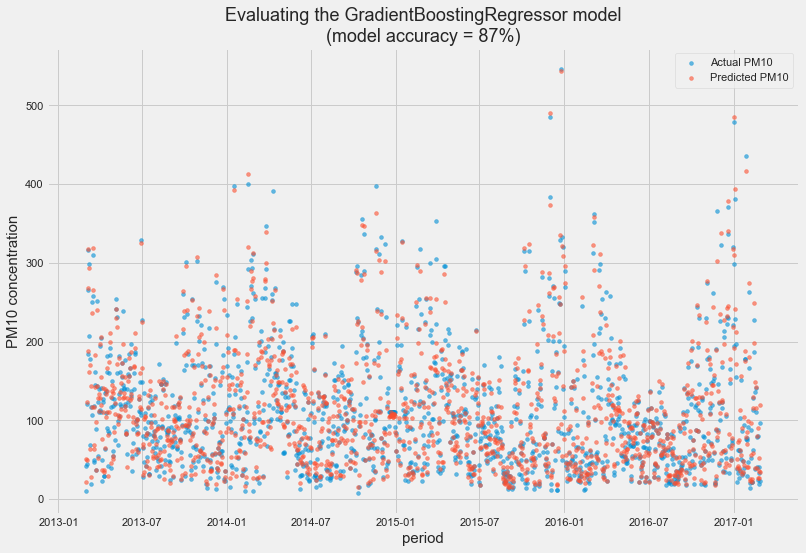

In [201]:
# we now use the best model (GradientBoostingRegressor model) to predict the PM2.5 
# concetration and compare it to the actual PM2.5 recorded in the data by means of
# visualization

compare_data = pd.DataFrame({'dates':data['date'],
                            'Actual PM10':y,
                            'Predicted PM10':grad_boost.predict(X.values)})

compare_data.set_index('dates',inplace=True)
compare_data['Predicted PM10'] = np.round(compare_data['Predicted PM10'],1)

# let's plot the daily averages of the Actual PM10 and the predicted PM10 concentration.
compare_data = compare_data.resample('D').mean()

with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(12,8))
    plt.scatter(compare_data.index,compare_data['Actual PM10'],s=15,label='Actual PM10',
               alpha=.6)
    plt.scatter(compare_data.index,compare_data['Predicted PM10'],s=15,label='Predicted PM10',
               alpha=.6)
    plt.legend()
    plt.title('Evaluating the GradientBoostingRegressor model\n(model accuracy = 87%)',
             fontsize=18)
    plt.xlabel('period',fontsize=15)
    plt.ylabel('PM10 concentration',fontsize=15)
    plt.show()